In [192]:
import os
import sys
import mne
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mne.time_frequency import psd_array_multitaper

from settings import paths, quality_emg

from helper_functions import save_figure

In [242]:
# EMG frequency bands used for resting-state epoch classification (interpretation not comparable to EEG bands)
freq_bands_emg = {
    'band1': (0, 10), 'band2': (10, 20),
    'band3': (20, 30), 'band4': (30, 40),
    'band5': (40, 50), 'band6': (50, 60),
    'band7': (60, 70), 'band8': (70, 80),
    'band9': (80, 90), 'band10': (90, 100)
}

# EEG frequency bands used throughout the whole project for Power Spectral Density analysis
freq_bands_eeg = {
    r'$\delta$': (1, 4),  # Delta
    r'$\theta$': (4, 8),  # Theta
    r'$\alpha$': (8, 13),  # Alpha
    r'$\beta$': (13, 30),  # Beta
    r'$\gamma$': (30, 100)  # Gamma
}

Load functions for feature engineering

In [243]:
def calculate_emg_psd_features(signal, sfreq):
    psd, freq = psd_array_multitaper(signal, fmin=0, fmax=100, sfreq=sfreq, n_jobs=-1, verbose=False)

    psds = {}  # slice psd data of epoch based on the defined bands
    for band, (start, end) in freq_bands_emg.items():
        slice_start, slice_end = int(start / 100 * len(freq)), int(end / 100 * len(freq))
        psd_slice = psd[slice_start:slice_end]

        psds[f"EMG {band}"] = np.mean(np.log(psd_slice))

    psds['EMG high-low freq ratio'] = ((psds['EMG band1'] + psds['EMG band2']) / (psds['EMG band10'] + psds['EMG band9']))

    return psds

def calculate_eeg_psd_features(signal, sfreq):
    eeg_psds = {}
    for band, (start, end) in freq_bands_eeg.items():
        psd, freq = psd_array_multitaper(signal, fmin=start, fmax=end, sfreq=sfreq, n_jobs=-1)

        eeg_psds[f"OFC_L {band}"] = np.mean(np.log(psd))

    eeg_psds['gamma-delta ratio'] = (eeg_psds['OFC_L $\\delta$'] / eeg_psds['OFC_L $\\gamma$'])
    return eeg_psds

Now the main function that calls the above functions

In [244]:
def engineer_features(non_mov_epochs, subject_id, sfreq, wanted_chans):
    """
    Engineers desired features for the given subject. If there are two quality EMG channels,
    then the features derived from both EMG channels are averaged.

    :param non_mov_epochs: the subject's epochs
    :param subject_id: the id of the subject
    :param sfreq: sampling frequency of the EEG
    :param wanted_chans: indexes used to retrieve right epoch data (one EEG channel, and one EMG channels)
    :return:
    """
    print(f'Engineering features..')

    all_features = []  # list holding dict with all features per epoch

    # loop through the epochs in the subject's epochs
    for i, epoch in enumerate(non_mov_epochs):
        # features per epoch are stored in here
        features = {
            'subject_id': subject_id,
            'epoch_n': non_mov_epochs.metadata.iloc[i].name,
            'movement': non_mov_epochs.metadata["movement"].iloc[i],
            'frame_start_end': non_mov_epochs.metadata["epochs_start_end_frames"].iloc[i]
        }

        # for all wanted_chans, calculate the desired features
        for chan_type, chan_index in wanted_chans.items():
            if chan_type == 'EEG':
                # we only wish to calc PSD features using one chan, so get first index and then the data
                eeg_chan_data = epoch[chan_index, :]

                # get eeg psd features with right data from epoch
                features.update(calculate_eeg_psd_features(eeg_chan_data, sfreq))

            # if the looped channel type we need to calc features for is EMG, then we end up here
            if chan_type == 'EMG':

                # if there's only one EMG channel, save its features
                channel_data = epoch[chan_index, :]
                features.update(calculate_emg_psd_features(channel_data, sfreq))

        # store this epoch's features in the list
        all_features.append(features)

    print(f'Done engineering features.')

    return pd.DataFrame(all_features)

Define the wanted channels to derive features from

In [245]:
def get_wanted_chans(subject_epochs, subject_id):
    wanted_eeg_chan = 'OFC_L'
    wanted_emg_chan = quality_emg[int(subject_id)]
    recorded_chans = subject_epochs.info['ch_names']
    wanted_chan_indexes = {
        'EEG': [index for index, value in enumerate(recorded_chans) if value == wanted_eeg_chan][0],
        'EMG': [index for index, value in enumerate(recorded_chans) if value == wanted_emg_chan][0]
    }
    return wanted_chan_indexes

## 39508, a good quality separation example

In [ ]:
epochs_39508 = mne.read_epochs(os.path.join(paths["epochs_folder"], "filtered_epochs_w_movement_39508-epo.fif"),preload=True)
epochs_39508 = epochs_39508[:-1]  # somehow the last epoch holds only zeros
epochs_39508.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

In [246]:
non_mov_39508 = epochs_39508[epochs_39508.metadata['movement'] == 0]
features_39508 = engineer_features(non_mov_39508, '39508', epochs_39508.info['sfreq'], get_wanted_chans(epochs_39508, '39508'))

Engineering features..
Done engineering features.


In [247]:
df_numeric = features_39508.iloc[:, 4:]
feature_names = df_numeric.columns
df_numeric.head()

,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-13.580723,-14.346173,-14.237211,-16.844413,-17.501651,0.775968,-15.811422,-17.162293,-17.862393,-18.361798,-17.911074,-18.545229,-18.342799,-18.454851,-18.705182,-18.482485,0.886684
1,-12.708286,-13.251085,-14.909869,-16.759986,-17.782877,0.714636,-15.514908,-17.704031,-18.060586,-18.438066,-18.461283,-18.942014,-18.462417,-18.477012,-18.805324,-18.529427,0.889759
2,-13.000937,-12.513695,-15.146621,-16.703464,-17.720422,0.733670,-15.768436,-17.776696,-18.680256,-18.534022,-19.039441,-19.168212,-18.920294,-19.408564,-19.495606,-19.115775,0.868789
3,-12.857127,-13.332727,-14.892472,-16.905170,-17.745892,0.724513,-15.666305,-17.603781,-17.672099,-18.210353,-17.994014,-18.625255,-18.566366,-18.706818,-18.830411,-18.501657,0.891193
4,-12.809237,-13.280218,-14.513769,-16.761566,-17.275025,0.741489,-15.376889,-17.518799,-18.421073,-18.629621,-18.237068,-18.770884,-18.809124,-18.704513,-18.917884,-18.843330,0.871150


In [248]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
kmeans = KMeans(random_state=40, n_clusters=3)
kmeans.fit(scaled_features)

KMeans(n_clusters=3, random_state=40)

In [249]:
print(f'There are 3 clusters with sizes: {np.unique(kmeans.labels_, return_counts=True)[1]}')

# add PCA components 1 and 2 to df and add cluster labels
df_plot = pd.concat([features_39508.reset_index(drop=True), pd.DataFrame(comp)], axis=1)
df_plot["cluster"] = kmeans.labels_

There are 3 clusters with sizes: [211 152  26]


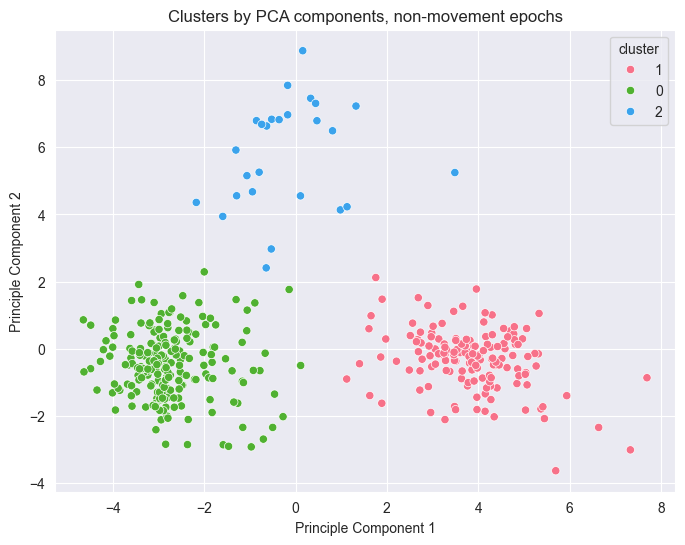

In [250]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="cluster", hue_order=[1,0,2],  palette=sns.color_palette("husl", 3))
plt.title("Clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

### DBSCAN clustering

Fit tSNE and save axes to the plot_df

In [251]:
model = TSNE(learning_rate=1000, random_state=42)
transformed = model.fit_transform(scaled_features)
df_plot['tsne_x'] = transformed[:, 0]
df_plot['tsne_y'] = transformed[:, 1]

In [257]:
from sklearn.cluster import DBSCAN
plt.rcParams.update({'text.usetex': False})
dbscan = DBSCAN(eps=.8, min_samples=3)
clusters = dbscan.fit_predict(df_numeric)
df_plot['clusters_db'] = clusters

print("Amount of data-points per cluster: ", np.unique(dbscan.labels_, return_counts=True)[1])
print("Number of features seen during fit: ", dbscan.n_features_in_)

Amount of data-points per cluster:  [105 101  11 169   3]
Number of features seen during fit:  17


Let's plot the epochs along the by T-SNE reduced axes with the by DB-SCAN classified cluster labels.

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_18976/3922867704.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=df_plot, x='tsne_x', y='tsne_y', hue="clusters_db", palette=sns.color_palette("husl"))


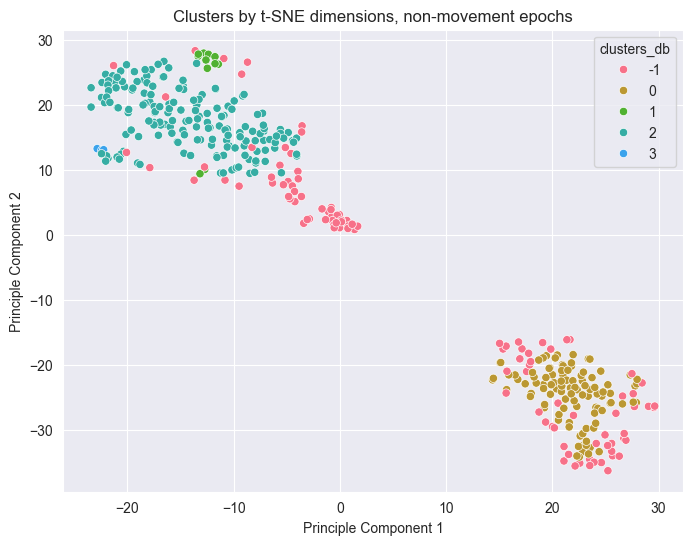

In [258]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x='tsne_x', y='tsne_y', hue="clusters_db", palette=sns.color_palette("husl"))
plt.title("Clusters by t-SNE dimensions, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

Now, let's plot the epochs along the by PCA reduced axes with the by DB-SCAN classified cluster labels.

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_18976/2170578847.py:2: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_db", palette=sns.color_palette("husl"))


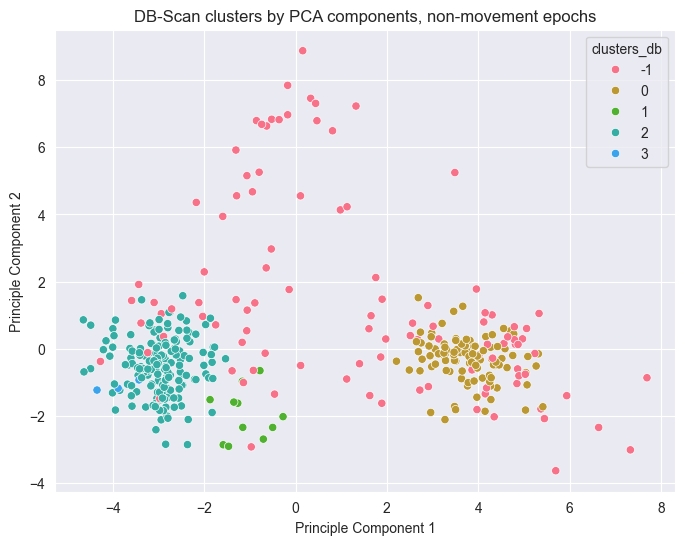

In [259]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_db", palette=sns.color_palette("husl"))
plt.title("DB-Scan clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

Let's remove the -1 anomalies, as well as the very small clusters.

Then, we again plot the datapoints along the PCA axes, and color by DB-SCAN cluster.

Amount of data-points per cluster:  [101  11 169]


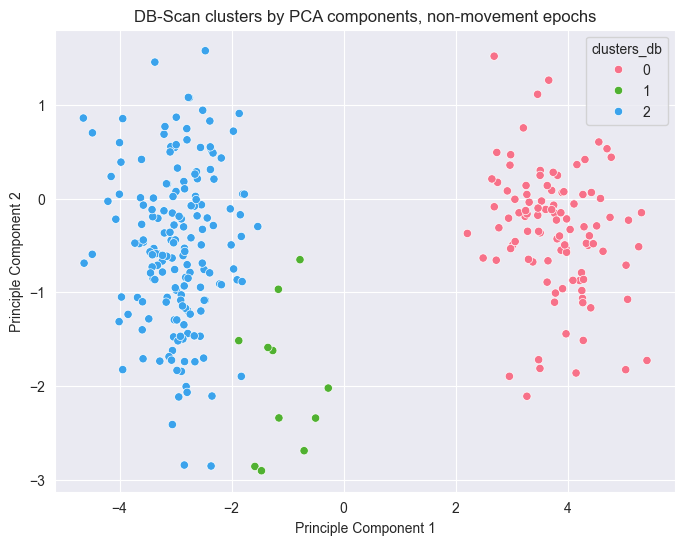

In [260]:
df_plot_wo_anomalies = df_plot[~df_plot['clusters_db'].isin([-1, 3, 4])]
print("Amount of data-points per cluster: ", np.unique(df_plot_wo_anomalies['clusters_db'], return_counts=True)[1])

# plot again
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot_wo_anomalies, x=0, y=1, hue="clusters_db", palette=sns.color_palette("husl", 3))
plt.title("DB-Scan clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

### GaussianMixture

In [261]:
from sklearn.mixture import GaussianMixture

# define the model
gaussian_model = GaussianMixture(n_components=2)
# train the model
gaussian_model.fit(df_numeric)
# assign each data point to a cluster
gaussian_result = gaussian_model.predict(df_numeric)
df_plot['clusters_mix'] = gaussian_result

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_18976/23633540.py:2: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_mix", palette=sns.color_palette("husl", 3))


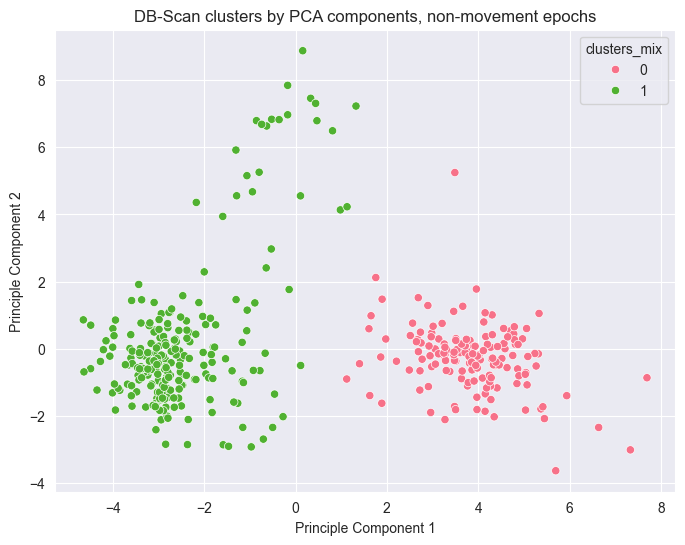

In [263]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_mix", palette=sns.color_palette("husl", 3))
plt.title("DB-Scan clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

#### Mean-Shift

In [267]:
from sklearn.cluster import MeanShift

mean_model = MeanShift()
mean_result = mean_model.fit_predict(df_numeric)
df_plot['clusters_meanshift'] = mean_result
np.unique(mean_result, return_counts=True)[1]

array([212, 147,  21,   1,   5,   3])

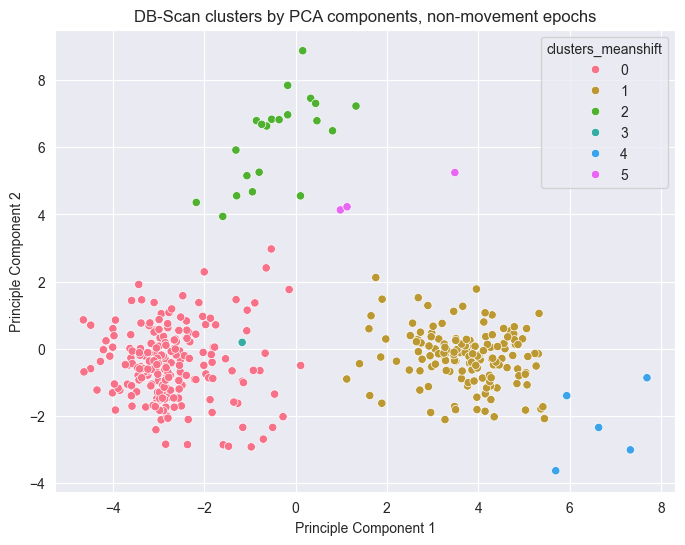

In [268]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_meanshift", palette=sns.color_palette("husl", 6))
plt.title("DB-Scan clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

#### OPTICS

In [284]:
from sklearn.cluster import OPTICS

# define the model
optics_model = OPTICS(min_samples=8, min_cluster_size=16)
optics_result = optics_model.fit_predict(df_numeric)
df_plot['clusters_optics'] = optics_result
np.unique(optics_result, return_counts=True)[1]

array([ 12, 147, 211,  19])

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_18976/3317553163.py:2: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_optics", palette=sns.color_palette("husl", 6))


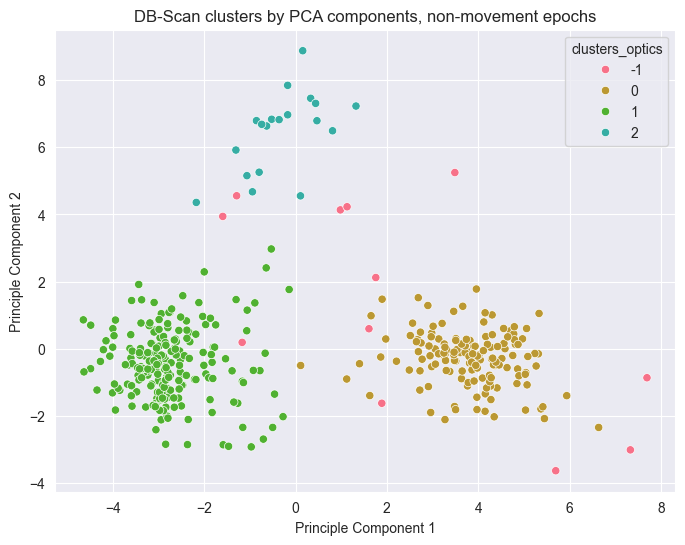

In [285]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_optics", palette=sns.color_palette("husl", 6))
plt.title("DB-Scan clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

## 80625, a more challenging separation example

In [286]:
epochs_80625 = mne.read_epochs(os.path.join(paths["epochs_folder"], "filtered_epochs_w_movement_80625-epo.fif"), preload=True)
epochs_80625 = epochs_80625[:-1]  # somehow the last epoch holds only zeros
epochs_80625.drop_channels(['OFC_R', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R'])

Number of events,1544
Events,1: 1544
Time range,0.000 – 4.999 s
Baseline,off


In [287]:
non_mov_80625 = epochs_80625[epochs_80625.metadata['movement'] == 0]
features_80625 = engineer_features(non_mov_80625, '80625', epochs_80625.info['sfreq'], get_wanted_chans(epochs_80625, '80625'))

Engineering features..
Done engineering features.


In [288]:
df_numeric = features_80625.iloc[:, 4:]
feature_names = df_numeric.columns
df_numeric.head()

,OFC_L $\delta$,OFC_L $\theta$,OFC_L $\alpha$,OFC_L $\beta$,OFC_L $\gamma$,gamma-delta ratio,EMG band1,EMG band2,EMG band3,EMG band4,EMG band5,EMG band6,EMG band7,EMG band8,EMG band9,EMG band10,EMG high-low freq ratio
0,-15.826677,-16.365108,-15.946520,-18.029519,-18.899249,0.837424,-16.069324,-17.425135,-18.056118,-18.119496,-18.151192,-18.683983,-18.698573,-18.501623,-18.583025,-17.946377,0.916918
1,-15.567960,-15.691947,-16.063244,-17.421022,-18.753765,0.830125,-15.709721,-17.559035,-18.094597,-18.470368,-18.513797,-18.823047,-18.310157,-18.697271,-18.707440,-18.529400,0.893437
2,-15.047281,-15.192003,-16.372403,-17.978878,-18.718807,0.803859,-15.899201,-17.709568,-18.518964,-18.347886,-18.781456,-18.906762,-18.420800,-18.558848,-18.659125,-18.659062,0.900600
3,-15.477481,-15.116941,-16.414383,-17.502805,-18.703929,0.827499,-16.045884,-17.603680,-18.338061,-18.568886,-19.059590,-19.078569,-18.733511,-18.803696,-18.719771,-18.948368,0.893316
4,-15.571145,-15.174178,-15.867502,-17.701516,-18.704417,0.832485,-15.910047,-17.834114,-18.429282,-18.390033,-18.463950,-18.517219,-18.528908,-18.796042,-18.943453,-18.633807,0.897994


In [289]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_features)
kmeans = KMeans(random_state=40, n_clusters=3)
kmeans.fit(scaled_features)

KMeans(n_clusters=3, random_state=40)

In [290]:
print(f'There are 3 clusters with sizes: {np.unique(kmeans.labels_, return_counts=True)[1]}')

# add PCA components 1 and 2 to df and add cluster labels
df_plot = pd.concat([features_80625.reset_index(drop=True), pd.DataFrame(comp)], axis=1)
df_plot["cluster"] = kmeans.labels_

There are 3 clusters with sizes: [167 603 128]


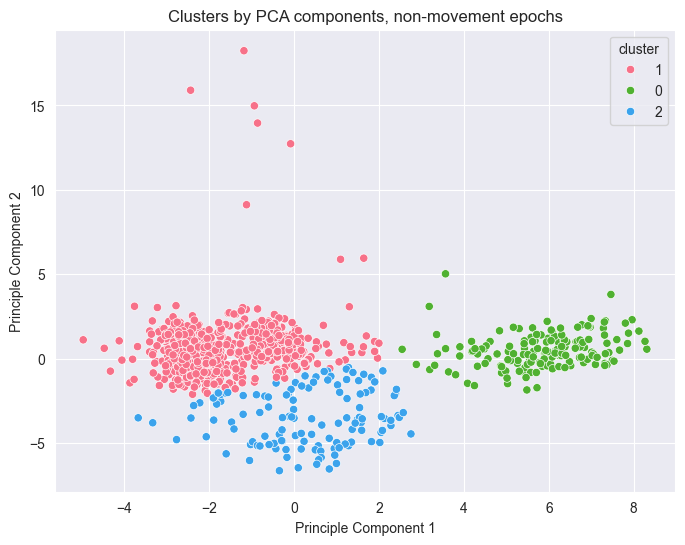

In [291]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="cluster", hue_order=[1,0,2],  palette=sns.color_palette("husl", 3))
plt.title("Clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

### DBSCAN clustering

Fit tSNE and save axes to the plot_df

In [238]:
model = TSNE(learning_rate=1000, random_state=42)
transformed = model.fit_transform(scaled_features)
df_plot['tsne_x'] = transformed[:, 0]
df_plot['tsne_y'] = transformed[:, 1]

Add DBSCAN cluster labels to the plot_df

In [239]:
from sklearn.cluster import DBSCAN
plt.rcParams.update({'text.usetex': False})
dbscan = DBSCAN(eps=.65, min_samples=4)
clusters = dbscan.fit_predict(df_numeric)
df_plot['clusters_db'] = clusters

print("Amount of data-points per cluster: ", np.unique(dbscan.labels_, return_counts=True)[1])
print("Number of features seen during fit: ", dbscan.n_features_in_)

Amount of data-points per cluster:  [127 142 574  44   4   7]
Number of features seen during fit:  11


Let's plot the epochs along the by T-SNE reduced axes with the by DB-SCAN classified cluster labels.

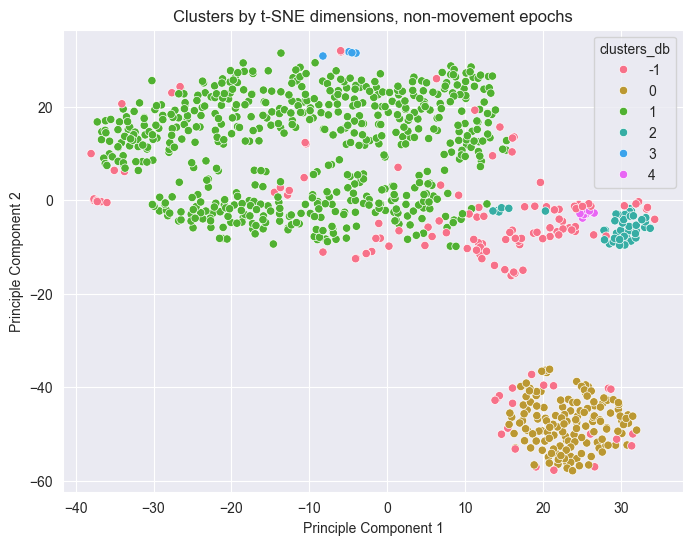

In [240]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x='tsne_x', y='tsne_y', hue="clusters_db", palette=sns.color_palette("husl"))
plt.title("Clusters by t-SNE dimensions, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

Now, let's plot the epochs along the by PCA reduced axes with the by DB-SCAN classified cluster labels.

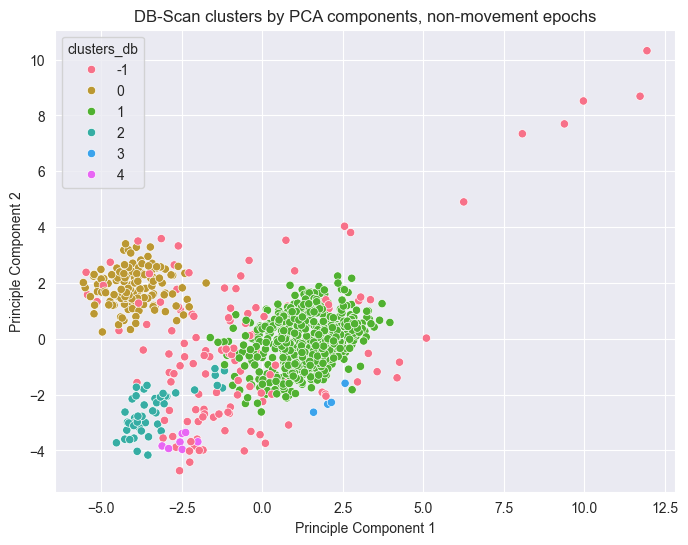

In [241]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_db", palette=sns.color_palette("husl"))
plt.title("DB-Scan clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

Let's remove the -1 anomalies, as well as the very small clusters.

Then, we again plot the datapoints along the PCA axes, and color by DB-SCAN cluster.

Amount of data-points per cluster:  [149 608  38]


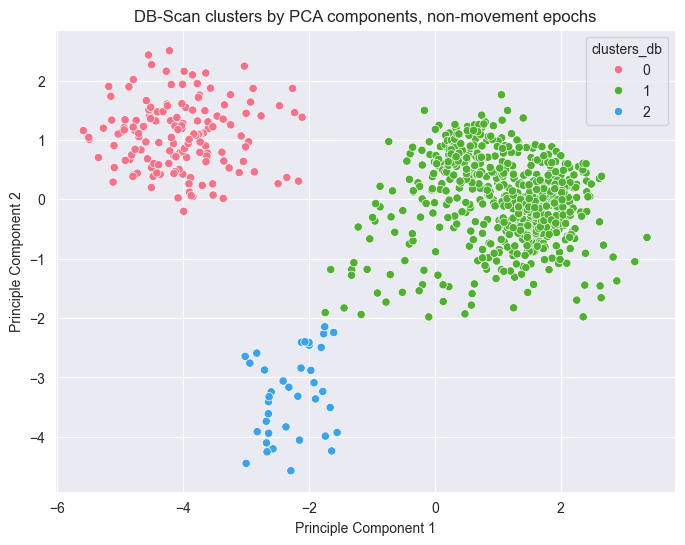

In [134]:
df_plot_wo_anomalies = df_plot[~df_plot['clusters_db'].isin([-1, 3, 4])]
print("Amount of data-points per cluster: ", np.unique(df_plot_wo_anomalies['clusters_db'], return_counts=True)[1])

# plot again
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot_wo_anomalies, x=0, y=1, hue="clusters_db", palette=sns.color_palette("husl", 3))
plt.title("DB-Scan clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

In [299]:
from sklearn.cluster import OPTICS

# define the model
optics_model = OPTICS(min_samples=7)
optics_result = optics_model.fit_predict(df_numeric)
df_plot['clusters_optics'] = optics_result
np.unique(optics_result, return_counts=True)[1]

array([ 20, 878])

/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_18976/3317553163.py:2: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_optics", palette=sns.color_palette("husl", 6))


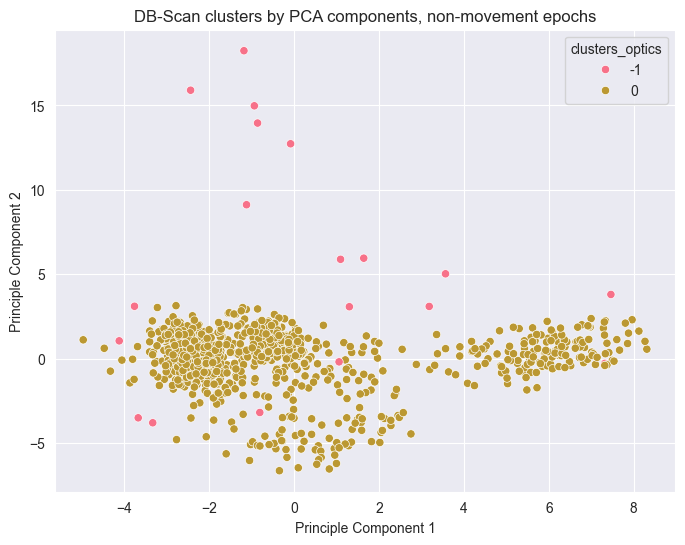

In [300]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="clusters_optics", palette=sns.color_palette("husl", 6))
plt.title("DB-Scan clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()